# **1. PERKENALAN** 
Nama : Al Izhar Iqrami

Batch : 11 Data Science Hacktive8

## Introduction
----
PROBLEM


Sampah adalah masalah global yang signifikan. Peningkatan volume sampah dihasilkan seiring dengan meningkatnya populasi global dan standar hidup. Orang-orang semakin khawatir tentang produksi limbah dan pengaruhnya, serta mencari cara untuk mengatasi masalah tersebut.

Daur ulang adalah proses mengubah bahan limbah menjadi bahan dan benda baru. Pemulihan energi dari bahan limbah sering dimasukkan dalam konsep ini. Daur ulang suatu bahan tergantung pada kemampuannya untuk memperoleh kembali sifat-sifat yang dimilikinya dalam keadaan aslinya. Ini adalah alternatif untuk pembuangan limbah "konvensional" yang dapat menghemat bahan dan membantu menurunkan emisi gas rumah kaca. Daur ulang dapat mencegah pemborosan bahan yang berpotensi berguna dan mengurangi konsumsi bahan baku segar, sehingga mengurangi: penggunaan energi, polusi udara (dari insinerasi), dan polusi air (dari penimbunan).

Berdasarkan permasalahan diatas, maka saya tertarik untuk membuat sebuah model yang dapat mengklasifikasikan sampah organik dan sampah yang dapat di daur ulang. Dengan demikian dapat mengatasi permasalahn diatas dan juga dapat meningkatkan produktifitas UMKM yang bergerak di bidang kreatifitas menggunakan bahan dasar dari sampah.

# **2. IMPORT LIBRARY**

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten, MaxPool2D

from sklearn.model_selection import train_test_split
from IPython import display 
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

Melakuakn import library yang berguna untuk membatu memecahkan permasalahan yang diperolah pada saat melakuakan analisis data

# **3. DATA LOADING**

## Connect Kaggle and Google Collaboratory 

In [2]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle

!mkdir ./kaggle 
!mv ./kaggle.json ./kaggle 

cp: cannot stat 'kaggle.json': No such file or directory
mkdir: cannot create directory ‘./kaggle’: File exists
mv: cannot stat './kaggle.json': No such file or directory


In [3]:
!chmod 600 ~/.kaggle/kaggle.json 
!ls ~/.kaggle 

kaggle.json


In [4]:
!kaggle datasets download -d techsash/waste-classification-data

waste-classification-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
#!unzip -q /content/waste-classification-data.zip -d images

# **4. Exploratory Data Analysis (EDA)**

Terlihat bahwa pada data set yang kita miliki telah telah terdapat folder data test dan train

In [6]:
main_path = '/content/images/DATASET'
train_dir = os.path.join(main_path, 'TRAIN')
test_dir = os.path.join(main_path, 'TEST')

In [7]:
# Mengecek list directory
dir_name= os.listdir('/content/images/DATASET')
dir_name

['TEST', 'TRAIN']

In [8]:
# Membagi data train_dir berdasarkan data Organic dan Recyclable
num_organic = len(os.listdir(os.path.join(train_dir, 'O')))
num_recyclable = len(os.listdir(os.path.join(train_dir, 'R')))

In [9]:
# Melihat jumlah data sampah Organic dan Recyclabe
print('Jumlah organic images :', num_organic)
print('Jumlah recyclable images :', num_recyclable)

Jumlah organic images : 12565
Jumlah recyclable images : 9999


Terlihat bahwa kita memiliki 9999 data organic dan dan 12565 data recyclable

In [10]:
train_recyclable = glob.glob(train_dir + '/R/*.jpg')
train_organic = glob.glob(train_dir + '/O/*.jpg')

test_recyclable = glob.glob(test_dir + '/R/*.jpg')
test_organic = glob.glob(test_dir + '/O/*.jpg')

rec = len(train_recyclable)
org = len(train_organic)

rec1 = len(test_recyclable)
org1 = len(test_organic)

print('Jumlah sampel train : {}'.format(rec+org))
print('Jumlah sampel test : {}'.format(rec1+org1))

Jumlah sampel train : 22564
Jumlah sampel test : 2513


Terlihat bahwa jumlah sampe untuk data train yaitu 22564 dan data test berjumlag 2513

## Menampilkan ke Bentuk Data Frame

In [11]:
def create_dataframe(list_of_images):
  data = []
  for image in list_of_images:
    data.append((image, image.split('/')[-2]))

  return pd.DataFrame(data, columns = ['images', 'label'])

train_df = create_dataframe(train_recyclable + train_organic)
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

test_df = create_dataframe(test_recyclable + test_organic)
test_df = test_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [12]:
print(train_df.shape)
train_df

(22564, 2)


,images,label
0,/content/images/DATASET/TRAIN/O/O_6372.jpg,O
1,/content/images/DATASET/TRAIN/O/O_1327.jpg,O
2,/content/images/DATASET/TRAIN/O/O_4987.jpg,O
3,/content/images/DATASET/TRAIN/R/R_6899.jpg,R
4,/content/images/DATASET/TRAIN/R/R_7551.jpg,R
...,...,...
22559,/content/images/DATASET/TRAIN/O/O_959.jpg,O
22560,/content/images/DATASET/TRAIN/O/O_9821.jpg,O
22561,/content/images/DATASET/TRAIN/R/R_5657.jpg,R
22562,/content/images/DATASET/TRAIN/O/O_7754.jpg,O


In [13]:
# Check Jumlag Baris Dan Kolom
print(test_df.shape)

(2513, 2)


In [14]:
# Null check
print("Null data : {}".format(train_df.isnull().sum()))

Null data : images    0
label     0
dtype: int64


## Organic vs Recyclable

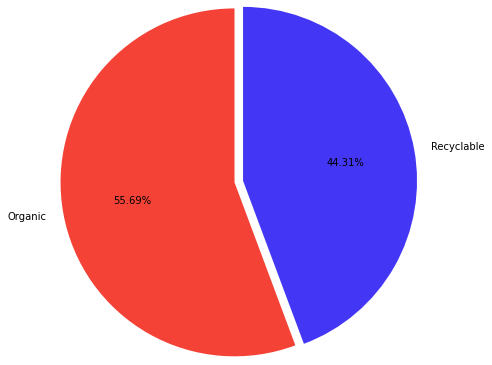

In [15]:
plt.pie(train_df.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors=['#f44336','#4336f4'], radius=2)
plt.show()

Berdasarkan data yang dimiliki, terlihat bahwa sampah organic memiliki persentase sebesar 55.69% dan sampah Recyclable memiliki persentase 44.31%. Selisih antara fitur tidaklah berbeda jauh, sehingga kami tidak malkukan handling imbalance data

# **5. DATA PREPROCESSING**

## Split Dataset

In [16]:
val_df, test_df= train_test_split(test_df, test_size=0.25, random_state=1)
print(test_df.shape)
print(val_df.shape)

(629, 2)
(1884, 2)


## Data Augmentation

In [17]:
# Augmentasi data
train_datagen= ImageDataGenerator(
    rescale= 1./255,
    rotation_range= 0.2,
    width_shift_range= 0.2,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    vertical_flip = True
)

val_datagen= ImageDataGenerator(rescale= 1./255)
test_datagen= ImageDataGenerator(rescale= 1./255)


## Train dataset, Validate datset and Test dataset

In [18]:
ds_train= train_datagen.flow_from_dataframe(
    dataframe= train_df,
    x_col= 'images',
    y_col= 'label',
    target_size= (220,220),
    class_mode= 'binary',
    batch_size= 32,
    shuffle= True,
    seed= 1
)

ds_val= val_datagen.flow_from_dataframe(
    dataframe= val_df,
    x_col= 'images',
    y_col= 'label',
    target_size= (220,220),
    class_mode= 'binary',
    batch_size= 32,
    shuffle= False,
    seed= 1
)

ds_test= test_datagen.flow_from_dataframe(
    dataframe= test_df,
    x_col= 'images',
    y_col= 'label',
    target_size= (220,220),
    class_mode= 'binary',
    batch_size= 32,
    shuffle= False,
    seed= 1
)

Found 22564 validated image filenames belonging to 2 classes.
Found 1884 validated image filenames belonging to 2 classes.
Found 629 validated image filenames belonging to 2 classes.


## Check Class

In [19]:
print(ds_train.class_indices)
print(ds_test.class_indices)

{'O': 0, 'R': 1}
{'O': 0, 'R': 1}


## Menampilkan Data Organic dan Recyclable

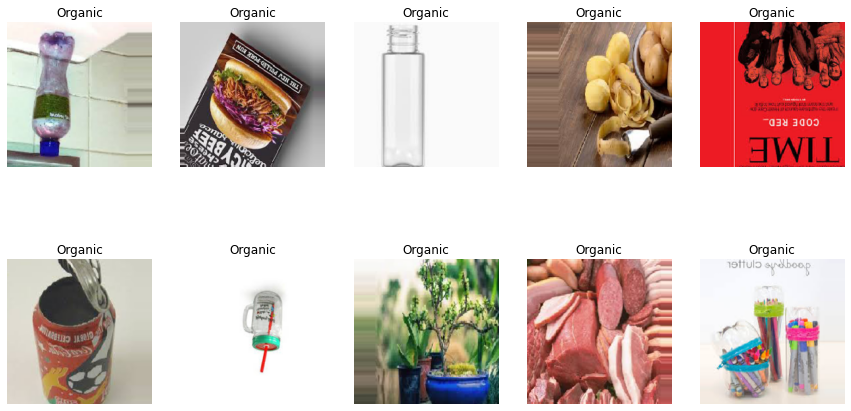

In [20]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (15,8))

for j in range(2):
    for k in range(5):
        random1 = np.random.randint(len(ds_train))
        random2 = np.random.randint(32)
        ax[j,k].imshow(ds_train[random1][0][random2])
        ax[j,k].axis('off')
        label = ds_train[random1][1][random2]
        if label =='O':
            ax[j,k].set_title('Recycle')
        else:
            ax[j,k].set_title('Organic')

plt.tight_layout
plt.show()

## Callbacks

In [21]:
callbacks= [
            EarlyStopping(monitor= 'val_loss', mode='min', patience= 3, verbose=1),
            ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only= True)
]

## Visualization of Augmentation

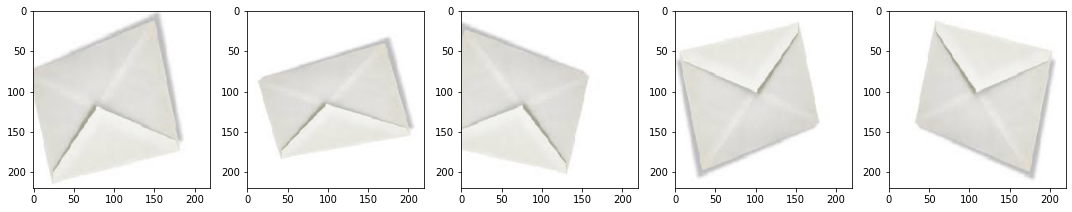

In [22]:
def Images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_img = [ds_train[0][0][0] for i in range(5)]
Images(augmented_img)

Gambar diatas merupakan hasil dari augmentasi

# **6. PEMODELAN**

In [23]:
# Setting random seed
np.random.seed(50)
tf.random.set_seed(50)

In [24]:
# Seting ukuran image
img_height= 220
img_width= 220
input= [img_height,img_width,3]

## Model Definition

Sebelum melakukan improvement lebih jauh, saya ingin melakukan pengecekan jumlah hidden layer terbaik yang akan digunakan. Selanjutnya jumlah hidden layer terbaik itulah yang akan dilakukan improvement lebih dalam

## Hidden Layer 3

In [25]:
model_seq_h3= Sequential()
model_seq_h3.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= input))
model_seq_h3.add(MaxPooling2D(pool_size=2, strides=2))

model_seq_h3.add(Conv2D(filters=32, kernel_size=3, activation= 'relu', input_shape= input))
model_seq_h3.add(MaxPooling2D(pool_size=2, strides=2))

model_seq_h3.add(Flatten())
model_seq_h3.add(Dense(units=64, activation= 'relu'))

model_seq_h3.add(Dense(units=1, activation= 'sigmoid'))

model_seq_h3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model_seq_h3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 89888)             0         
                                                                 
 dense (Dense)               (None, 64)                5

## Hidden Layer 4

In [26]:
model_seq_h4= Sequential()
model_seq_h4.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= input))
model_seq_h4.add(MaxPooling2D(pool_size=2, strides=2))

model_seq_h4.add(Conv2D(filters=32, kernel_size=3, activation= 'relu', input_shape= input))
model_seq_h4.add(MaxPooling2D(pool_size=2, strides=2))

model_seq_h4.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape= input))
model_seq_h4.add(MaxPooling2D(pool_size=2, strides=2))

model_seq_h4.add(Flatten())
model_seq_h4.add(Dense(units=128, activation= 'relu'))

model_seq_h4.add(Dense(units=1, activation= 'sigmoid'))

model_seq_h4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model_seq_h4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 109, 109, 16)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 51, 51, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 64)      

## Hidden Layer 5

In [27]:
model_seq_h5= Sequential()
model_seq_h5.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= input))
model_seq_h5.add(MaxPooling2D(pool_size=2, strides=2))

model_seq_h5.add(Conv2D(filters=32, kernel_size=3, activation= 'relu', input_shape= input))
model_seq_h5.add(MaxPooling2D(pool_size=2, strides=2))

model_seq_h5.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape= input))
model_seq_h5.add(MaxPooling2D(pool_size=2, strides=2))

model_seq_h5.add(Conv2D(filters=128, kernel_size=3, activation= 'relu', input_shape= input))
model_seq_h5.add(MaxPooling2D(pool_size=2, strides=2))

model_seq_h5.add(Flatten())
model_seq_h5.add(Dense(units=256, activation= 'relu'))

model_seq_h5.add(Dense(units=1, activation= 'sigmoid'))

model_seq_h5.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model_seq_h5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 109, 109, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 51, 51, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 25, 64)      

# **7. MODEL TRAINING**

## Hidden Layer 3

Epoch 1/50
22/22 [==============================] - 15s 517ms/step - loss: 0.9767 - accuracy: 0.6307 - val_loss: 0.5074 - val_accuracy: 0.7956
Epoch 2/50
22/22 [==============================] - 11s 523ms/step - loss: 0.4825 - accuracy: 0.7798 - val_loss: 0.4881 - val_accuracy: 0.8275
Epoch 3/50
22/22 [==============================] - 12s 556ms/step - loss: 0.4774 - accuracy: 0.7898 - val_loss: 0.4053 - val_accuracy: 0.8413
Epoch 4/50
22/22 [==============================] - 11s 507ms/step - loss: 0.4596 - accuracy: 0.7898 - val_loss: 0.4743 - val_accuracy: 0.7978
Epoch 5/50
22/22 [==============================] - 12s 564ms/step - loss: 0.4742 - accuracy: 0.7940 - val_loss: 0.3966 - val_accuracy: 0.8408
Epoch 6/50
22/22 [==============================] - 11s 501ms/step - loss: 0.4911 - accuracy: 0.7855 - val_loss: 0.4826 - val_accuracy: 0.8094
Epoch 7/50
22/22 [==============================] - 11s 503ms/step - loss: 0.4475 - accuracy: 0.8111 - val_loss: 0.4227 - val_accuracy: 0.8508

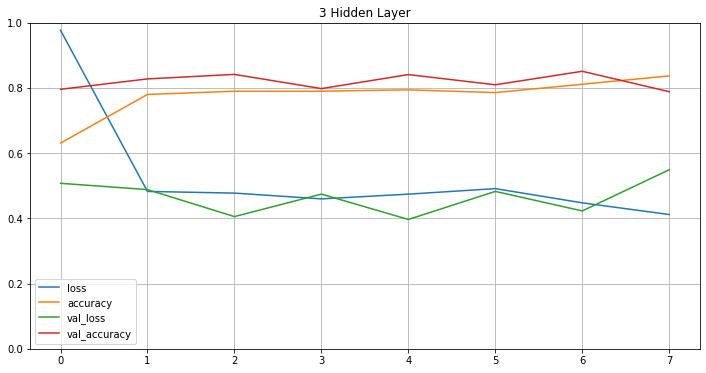

In [28]:
model_seq_h3_history = model_seq_h3.fit(ds_train, 
                                  epochs = 50, 
                                  validation_data= ds_val, 
                                  steps_per_epoch=int(len(ds_train)/32), 
                                  callbacks= callbacks,verbose=1) 

pd.DataFrame(model_seq_h3_history.history).plot(figsize=(12, 6))
plt.gca().set_ylim(0, 1)
plt.title('3 Hidden Layer')
plt.grid(True)
plt.show()

Berdasarkan ilustrasi dari grafik terlihat model yang didapatkan sudah cukup baik meskipun masih terdapat exponing gradient

## Hidden Layer 4

Epoch 1/50
22/22 [==============================] - 12s 516ms/step - loss: 0.8557 - accuracy: 0.6406 - val_loss: 0.4450 - val_accuracy: 0.8227
Epoch 2/50
22/22 [==============================] - 11s 508ms/step - loss: 0.4660 - accuracy: 0.7983 - val_loss: 0.4385 - val_accuracy: 0.8317
Epoch 3/50
22/22 [==============================] - 12s 569ms/step - loss: 0.4312 - accuracy: 0.8011 - val_loss: 0.3596 - val_accuracy: 0.8620
Epoch 4/50
22/22 [==============================] - 11s 515ms/step - loss: 0.4529 - accuracy: 0.7855 - val_loss: 0.3794 - val_accuracy: 0.8540
Epoch 5/50
22/22 [==============================] - 11s 514ms/step - loss: 0.4718 - accuracy: 0.8011 - val_loss: 0.3698 - val_accuracy: 0.8424
Epoch 6/50
22/22 [==============================] - 11s 513ms/step - loss: 0.4605 - accuracy: 0.7940 - val_loss: 0.3671 - val_accuracy: 0.8508
Epoch 6: early stopping


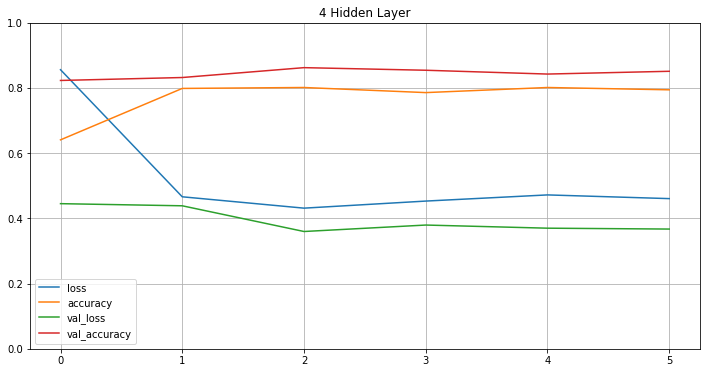

In [29]:
model_seq_h4_history = model_seq_h4.fit(ds_train, 
                                  epochs = 50, 
                                  validation_data= ds_val, 
                                  steps_per_epoch=int(len(ds_train)/32), 
                                  callbacks= callbacks,verbose=1) 

pd.DataFrame(model_seq_h4_history.history).plot(figsize=(12, 6))
plt.gca().set_ylim(0, 1)
plt.title('4 Hidden Layer')
plt.grid(True)
plt.show()

Berdasarkan ilustrasi dari grafik terlihat model yang didapatkan sudah cukup baik 

## Hidden Layer 5

Epoch 1/50
22/22 [==============================] - 12s 517ms/step - loss: 0.6540 - accuracy: 0.6562 - val_loss: 0.4695 - val_accuracy: 0.8397
Epoch 2/50
22/22 [==============================] - 11s 509ms/step - loss: 0.4941 - accuracy: 0.7812 - val_loss: 0.4730 - val_accuracy: 0.8248
Epoch 3/50
22/22 [==============================] - 11s 505ms/step - loss: 0.4982 - accuracy: 0.7656 - val_loss: 0.4780 - val_accuracy: 0.8041
Epoch 4/50
22/22 [==============================] - 11s 503ms/step - loss: 0.4694 - accuracy: 0.7841 - val_loss: 0.4353 - val_accuracy: 0.8402
Epoch 5/50
22/22 [==============================] - 11s 515ms/step - loss: 0.4626 - accuracy: 0.7926 - val_loss: 0.4428 - val_accuracy: 0.8047
Epoch 6/50
22/22 [==============================] - 11s 503ms/step - loss: 0.4746 - accuracy: 0.7926 - val_loss: 0.3824 - val_accuracy: 0.8439
Epoch 7/50
22/22 [==============================] - 12s 573ms/step - loss: 0.4395 - accuracy: 0.8092 - val_loss: 0.3736 - val_accuracy: 0.8567

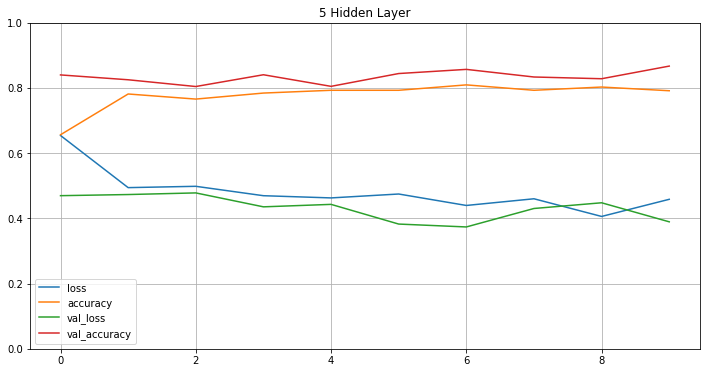

In [30]:
model_seq_h5_history = model_seq_h5.fit(ds_train, 
                                  epochs = 50, 
                                  validation_data= ds_val, 
                                  steps_per_epoch=int(len(ds_train)/32), 
                                  callbacks= callbacks,verbose=1) 

pd.DataFrame(model_seq_h5_history.history).plot(figsize=(12, 6))
plt.gca().set_ylim(0, 1)
plt.title('5 Hidden Layer')
plt.grid(True)
plt.show()

Berdasarkan ilustrasi dari grafik terlihat model yang didapatkan sudah cukup baik namun terdapat exponing gradient pada nilai loss

# **8. Evaluasi Model Berdasarkan Jumlah Hidden Layers**

In [32]:
loss, accuracy = model_seq_h3.evaluate(ds_test, verbose=False)
print("Testing Accuracy Dengan 3 Hidden Layer:  {:.4f}".format(accuracy))
loss, accuracy = model_seq_h4.evaluate(ds_test, verbose=False)
print("Testing Accuracy Dengan 4 Hidden Layer:  {:.4f}".format(accuracy))
loss, accuracy = model_seq_h5.evaluate(ds_test, verbose=False)
print("Testing Accuracy Dengan 5 Hidden Layer:  {:.4f}".format(accuracy))

Testing Accuracy Dengan 3 Hidden Layer:  0.8076
Testing Accuracy Dengan 4 Hidden Layer:  0.8871
Testing Accuracy Dengan 5 Hidden Layer:  0.8808


Berdasarkan nilai perbandingan accuracy, diperoleh jumlah hidden layer 3 adalah yang terbaik digunakan dalam kasus ini. Sehingga saya akan coba melakukan model improvement dengan jumlah hidden layer terbaik

# **9. Model Improvement**

Saya akan melakukan improvement bedasarkan model dengan jumlah hidden layer terbaik yaitu 4. Serta melakukan dropout sebesar 0.2 disetiap hidden layer.
Serta fokus utama ialah membandingkan performa model terbaik dengan melakukan perubahan pada optimizer


## Optimizer Adam

In [33]:
model_adam= Sequential()
model_adam.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= input))
model_adam.add(MaxPooling2D(pool_size=2, strides=2))
model_adam.add(Dropout(rate=0.2))

model_adam.add(Conv2D(filters=32, kernel_size=3, activation= 'relu', input_shape= input))
model_adam.add(MaxPooling2D(pool_size=2, strides=2))
model_adam.add(Dropout(rate=0.2))

model_adam.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape= input))
model_adam.add(MaxPooling2D(pool_size=2, strides=2))
model_adam.add(Dropout(rate=0.2))

model_adam.add(Flatten())
model_adam.add(Dense(units=128, activation= 'relu'))
model_adam.add(Dropout(rate=0.2))

model_adam.add(Dense(units=1, activation= 'sigmoid'))

model_adam.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model_adam.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 109, 109, 16)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 109, 109, 16)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 53, 53, 32)       

Epoch 1/10
22/22 [==============================] - 12s 514ms/step - loss: 1.5683 - accuracy: 0.5724 - val_loss: 0.6341 - val_accuracy: 0.5876
Epoch 2/10
22/22 [==============================] - 18s 833ms/step - loss: 0.5306 - accuracy: 0.7500 - val_loss: 0.4487 - val_accuracy: 0.8508
Epoch 3/10
22/22 [==============================] - 11s 522ms/step - loss: 0.4957 - accuracy: 0.7855 - val_loss: 0.4624 - val_accuracy: 0.8471
Epoch 4/10
22/22 [==============================] - 11s 506ms/step - loss: 0.4885 - accuracy: 0.7997 - val_loss: 0.4725 - val_accuracy: 0.8546
Epoch 5/10
22/22 [==============================] - 11s 500ms/step - loss: 0.5182 - accuracy: 0.7798 - val_loss: 0.5097 - val_accuracy: 0.8365
Epoch 5: early stopping


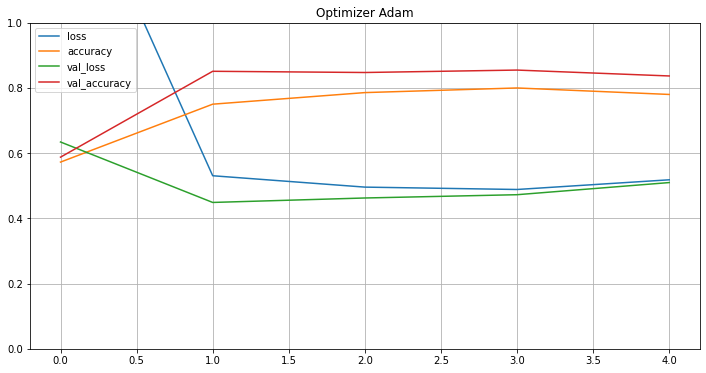

In [34]:
model_adam_history = model_adam.fit(ds_train, 
                                  epochs = 10, 
                                  validation_data= ds_val, 
                                  steps_per_epoch=int(len(ds_train)/32), 
                                  callbacks= callbacks,verbose=1) 

pd.DataFrame(model_adam_history.history).plot(figsize=(12, 6))
plt.gca().set_ylim(0, 1)
plt.title('Optimizer Adam')
plt.grid(True)
plt.show()

Berdasarkan visualisasi terlihat bahwa model sudah cukup baik, namun nilai loss pada epoch awal cukup overvitting

## Optimizer Nadam 

In [35]:
model_nadam= Sequential()
model_nadam.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= input))
model_nadam.add(MaxPooling2D(pool_size=2, strides=2))
model_nadam.add(Dropout(rate=0.2))

model_nadam.add(Conv2D(filters=32, kernel_size=3, activation= 'relu', input_shape= input))
model_nadam.add(MaxPooling2D(pool_size=2, strides=2))
model_nadam.add(Dropout(rate=0.2))

model_nadam.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape= input))
model_nadam.add(MaxPooling2D(pool_size=2, strides=2))
model_nadam.add(Dropout(rate=0.2))

model_nadam.add(Flatten())
model_nadam.add(Dense(units=128, activation= 'relu'))
model_nadam.add(Dropout(rate=0.2))

model_nadam.add(Dense(units=1, activation= 'sigmoid'))

model_nadam.compile(optimizer = 'nadam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model_nadam.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 109, 109, 16)     0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 109, 109, 16)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 53, 53, 32)       

Epoch 1/10
22/22 [==============================] - 18s 774ms/step - loss: 1.2723 - accuracy: 0.6065 - val_loss: 0.5444 - val_accuracy: 0.8259
Epoch 2/10
22/22 [==============================] - 14s 637ms/step - loss: 0.5938 - accuracy: 0.7027 - val_loss: 0.5080 - val_accuracy: 0.8270
Epoch 3/10
22/22 [==============================] - 15s 681ms/step - loss: 0.5081 - accuracy: 0.7670 - val_loss: 0.4735 - val_accuracy: 0.8424
Epoch 4/10
22/22 [==============================] - 12s 554ms/step - loss: 0.4966 - accuracy: 0.7486 - val_loss: 0.4756 - val_accuracy: 0.8439
Epoch 5/10
22/22 [==============================] - 11s 519ms/step - loss: 0.4644 - accuracy: 0.8111 - val_loss: 0.4391 - val_accuracy: 0.8503
Epoch 6/10
22/22 [==============================] - 12s 563ms/step - loss: 0.5011 - accuracy: 0.7756 - val_loss: 0.4688 - val_accuracy: 0.8094
Epoch 7/10
22/22 [==============================] - 15s 699ms/step - loss: 0.4647 - accuracy: 0.7912 - val_loss: 0.4413 - val_accuracy: 0.8609

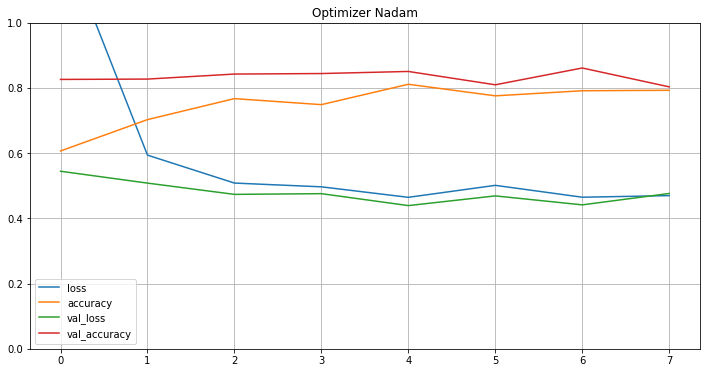

In [36]:
model_nadam_history = model_nadam.fit(ds_train, 
                                  epochs = 10, 
                                  validation_data= ds_val, 
                                  steps_per_epoch=int(len(ds_train)/32), 
                                  callbacks= callbacks,verbose=1) 

pd.DataFrame(model_nadam_history.history).plot(figsize=(12, 6))
plt.gca().set_ylim(0, 1)
plt.title('Optimizer Nadam')
plt.grid(True)
plt.show()

Berdasarkan visualisasi terlihat bahwa model sudah cukup baik, namun nilai loss dan accuracy pada epoch awal cukup overvitting

## Optimizer Adamax

In [37]:
model_adamax= Sequential()
model_adamax.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= input))
model_adamax.add(MaxPooling2D(pool_size=2, strides=2))
model_adamax.add(Dropout(rate=0.2))

model_adamax.add(Conv2D(filters=32, kernel_size=3, activation= 'relu', input_shape= input))
model_adamax.add(MaxPooling2D(pool_size=2, strides=2))
model_adamax.add(Dropout(rate=0.2))

model_adamax.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape= input))
model_adamax.add(MaxPooling2D(pool_size=2, strides=2))
model_adamax.add(Dropout(rate=0.2))

model_adamax.add(Flatten())
model_adamax.add(Dense(units=128, activation= 'relu'))
model_adamax.add(Dropout(rate=0.2))

model_adamax.add(Dense(units=1, activation= 'sigmoid'))

model_adamax.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])

model_adamax.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 109, 109, 16)     0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 109, 109, 16)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 53, 53, 32)       

Epoch 1/10
22/22 [==============================] - 16s 727ms/step - loss: 1.4784 - accuracy: 0.5213 - val_loss: 0.6916 - val_accuracy: 0.5563
Epoch 2/10
22/22 [==============================] - 14s 661ms/step - loss: 0.7046 - accuracy: 0.5199 - val_loss: 0.6906 - val_accuracy: 0.5605
Epoch 3/10
22/22 [==============================] - 11s 507ms/step - loss: 0.6828 - accuracy: 0.5369 - val_loss: 0.6786 - val_accuracy: 0.6768
Epoch 4/10
22/22 [==============================] - 11s 500ms/step - loss: 0.6549 - accuracy: 0.6278 - val_loss: 0.6342 - val_accuracy: 0.7861
Epoch 5/10
22/22 [==============================] - 11s 501ms/step - loss: 0.5784 - accuracy: 0.7259 - val_loss: 0.5522 - val_accuracy: 0.8402
Epoch 6/10
22/22 [==============================] - 11s 502ms/step - loss: 0.5525 - accuracy: 0.7159 - val_loss: 0.4956 - val_accuracy: 0.8328
Epoch 7/10
22/22 [==============================] - 11s 521ms/step - loss: 0.5271 - accuracy: 0.7386 - val_loss: 0.4982 - val_accuracy: 0.8227

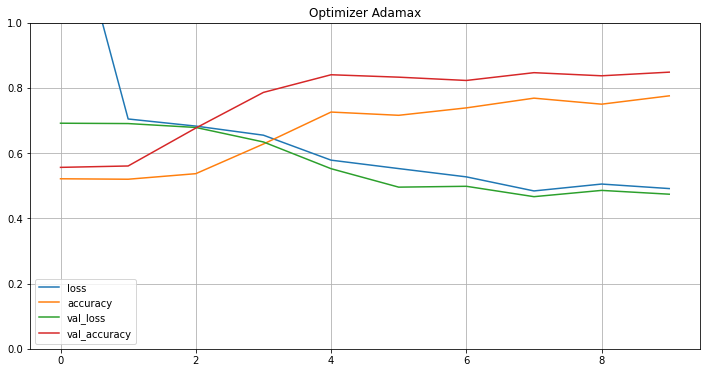

In [38]:
model_adamax_history = model_adamax.fit(ds_train, 
                                  epochs = 10, 
                                  validation_data= ds_val, 
                                  steps_per_epoch=int(len(ds_train)/32), 
                                  callbacks= callbacks,verbose=1)
 
pd.DataFrame(model_adamax_history.history).plot(figsize=(12, 6))
plt.gca().set_ylim(0, 1)
plt.title('Optimizer Adamax')
plt.grid(True)
plt.show()

Berdasarkan visualisasi terlihat bahwa model sudah cukup baik, namun nilai loss pada epoch awal cukup overvitting

## Optimizer SGD

In [39]:
model_sgd= Sequential()
model_sgd.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= input))
model_sgd.add(MaxPooling2D(pool_size=2, strides=2))
model_sgd.add(Dropout(rate=0.2))

model_sgd.add(Conv2D(filters=32, kernel_size=3, activation= 'relu', input_shape= input))
model_sgd.add(MaxPooling2D(pool_size=2, strides=2))
model_sgd.add(Dropout(rate=0.2))

model_sgd.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape= input))
model_sgd.add(MaxPooling2D(pool_size=2, strides=2))
model_sgd.add(Dropout(rate=0.2))

model_sgd.add(Flatten())
model_sgd.add(Dense(units=128, activation= 'relu'))
model_sgd.add(Dropout(rate=0.2))

model_sgd.add(Dense(units=1, activation= 'sigmoid'))

model_sgd.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])

model_sgd.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 109, 109, 16)     0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 109, 109, 16)      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 53, 53, 32)       

Epoch 1/10
22/22 [==============================] - 12s 507ms/step - loss: 0.7204 - accuracy: 0.5440 - val_loss: 0.6937 - val_accuracy: 0.4613
Epoch 2/10
22/22 [==============================] - 13s 590ms/step - loss: 0.6948 - accuracy: 0.5043 - val_loss: 0.6902 - val_accuracy: 0.6539
Epoch 3/10
22/22 [==============================] - 11s 502ms/step - loss: 0.6869 - accuracy: 0.5668 - val_loss: 0.6859 - val_accuracy: 0.7373
Epoch 4/10
22/22 [==============================] - 11s 510ms/step - loss: 0.6837 - accuracy: 0.5753 - val_loss: 0.6734 - val_accuracy: 0.5594
Epoch 5/10
22/22 [==============================] - 11s 506ms/step - loss: 0.6797 - accuracy: 0.5696 - val_loss: 0.6581 - val_accuracy: 0.7734
Epoch 6/10
22/22 [==============================] - 15s 688ms/step - loss: 0.6399 - accuracy: 0.6648 - val_loss: 0.6299 - val_accuracy: 0.7956
Epoch 7/10
22/22 [==============================] - 15s 709ms/step - loss: 0.6034 - accuracy: 0.6861 - val_loss: 0.5701 - val_accuracy: 0.7282

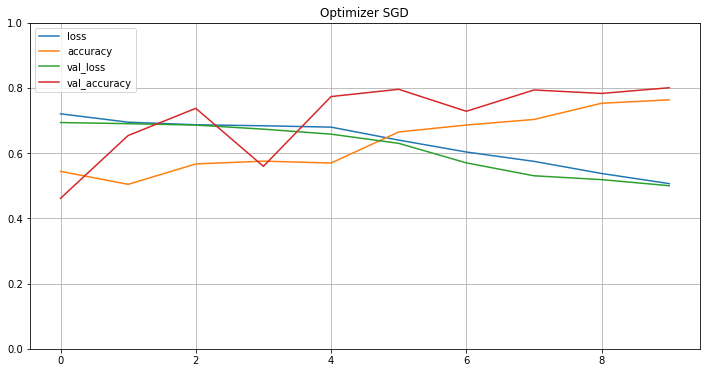

In [40]:
model_sgd_history = model_sgd.fit(ds_train, 
                                  epochs = 10, 
                                  validation_data= ds_val, 
                                  steps_per_epoch=int(len(ds_train)/32), 
                                  callbacks= callbacks,verbose=1) 

pd.DataFrame(model_sgd_history.history).plot(figsize=(12, 6))
plt.gca().set_ylim(0, 1)
plt.title('Optimizer SGD')
plt.grid(True)
plt.show()


Berdasarkan ilustrasi terlihat masih terdapat exponing gradient

## Evaluasi Model Hasil Improvement

**Perbandingan Nilai Accuracy**

In [41]:
loss, accuracy = model_adam.evaluate(ds_test, verbose=False)
print("Testing Accuracy Optimizer Adam :  {:.4f}".format(accuracy))
loss, accuracy = model_nadam.evaluate(ds_test, verbose=False)
print("Testing Accuracy Optimizer Nadam :  {:.4f}".format(accuracy))
loss, accuracy = model_adamax.evaluate(ds_test, verbose=False)
print("Testing Accuracy Optimizer Adamax :  {:.4f}".format(accuracy))
loss, accuracy = model_sgd.evaluate(ds_test, verbose=False)
print("Testing Accuracy Optimizer SGD :  {:.4f}".format(accuracy))

Testing Accuracy Optimizer Adam :  0.8649
Testing Accuracy Optimizer Nadam :  0.8283
Testing Accuracy Optimizer Adamax :  0.8808
Testing Accuracy Optimizer SGD :  0.8172


Berdasarkan perbandingan nilai accuracy, diperoleh model dengan optimizer Adamax adalah yang terbaik dengan nilai accuracy 88%. Namun jika dibandingkan dengan accuracy sebelum dilakukan improvement dengan jumlah hidden layer 4 memiliki nilai accuracy 89%. Namun saya lebih memilih model untuk proses prediksi dan deployment yaitu menggunakan Adamax karena informasi yang digali lebih dalam dan nilai accuracynya tidaklah jauh berbeda.

# **9. MODEL SAVING**

In [42]:
# Save model terbaik

model_adamax.save('model_adamax.hdf5')

# **10. MODEL INFERENCE**

In [43]:
# Membuat fungsi untuk mempermudah pemodelan

def prediksi(img):
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  result = model_adamax.predict(img)
  if result[0][0] == 1:
    print('Recyclable')
  else:
    print('Organic')

In [44]:
# Tes 1 - DATA ORGANIC

test_case1 = load_img(test_dir + '/O' + '/O_12569.jpg', target_size=(220, 220, 3))
prediksi(test_case1)

Organic


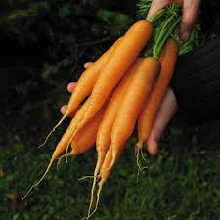

In [45]:
test_case1

In [46]:
# Test 2 - DATA RECYCLABLE

test_case2 = load_img(test_dir + '/R' + '/R_10003.jpg', target_size=(220, 220, 3))
prediksi(test_case2)

Recyclable


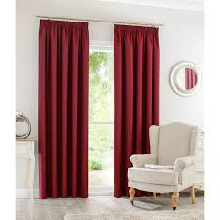

In [47]:
test_case2

# **11. KESIMPULAN**

## EDA

- Data image yang dimiliki sebanyak 22564 yang memiliki 2 kategori yaitu data organic dan recycled

- Berdasarkan data yang dimiliki, terlihat bahwa sampah organic memiliki persentase sebesar 55.69% dan sampah Recyclable memiliki persentase 44.31%. Selisih antara fitur tidaklah berbeda jauh, sehingga kami tidak malkukan handling imbalance data

## Model
Default :

- Testing Accuracy Dengan 3 Hidden Layer:  0.8076
- Testing Accuracy Dengan 4 Hidden Layer:  0.8871
- Testing Accuracy Dengan 5 Hidden Layer:  0.8808

Improvement :

Testing Accuracy Optimizer Adam   :  0.8649
Testing Accuracy Optimizer Nadam  :  0.8283
Testing Accuracy Optimizer Adamax :  0.8808
Testing Accuracy Optimizer SGD    :  0.8172

Berdasarkan perbandingan nilai accuracy, diperoleh model dengan optimizer Adamax adalah yang terbaik dengan nilai accuracy 88%. Namun jika dibandingkan dengan accuracy sebelum dilakukan improvement dengan jumlah hidden layer 4 memiliki nilai accuracy 89%. Namun saya lebih memilih model untuk proses prediksi dan deployment yaitu menggunakan Adamax karena informasi yang digali lebih dalam dan nilai accuracynya tidaklah jauh berbeda.

## SUMBER

- https://www.tensorflow.org/tutorials/images/classification
- https://www.kaggle.com/code/jonaspalucibarbosa/chest-x-ray-pneumonia-cnn-transfer-learning
- https://www.kaggle.com/datasets/techsash/waste-classification-data